In [ ]:
!pip install split-folders

In [ ]:
# import library yang dibutuhkan
import zipfile,os
import splitfolders as sf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop
from google.colab import files
from keras.preprocessing import image

In [ ]:
# mendownload datasets dari web dicoding
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rock_paper_scissors.zip

In [ ]:
# ekstraksi file zip yang telah didownload
import zipfile,os
local_zip = '/tmp/rock_paper_scissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# membagi folder menjadi train dan validation dengan split_folders
sf.ratio('/tmp/rockpaperscissors/rps-cv-images', output="/tmp/images", seed=1337, ratio=(.8, .2))
# membuat direktori data train dan data test
base_dir='/tmp/images'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [ ]:
os.listdir('/tmp/images')

In [ ]:
os.listdir('/tmp/images/train')
os.listdir('/tmp/images/val')

In [ ]:
print('total Train images :', len(os.listdir('/tmp/images/train/paper')) + len(os.listdir('/tmp/images/train/rock')) + len(os.listdir('/tmp/images/train/scissors')))
print('total Validation images :', len(os.listdir('/tmp/images/val/paper')) + len(os.listdir('/tmp/images/val/rock')) + len(os.listdir('/tmp/images/val/scissors')))

In [ ]:
train_rock_dir = os.path.join(train_dir, 'rock')  # directory data latih untuk gambar batu
train_paper_dir = os.path.join(train_dir, 'paper') # directory data latih untuk gambar kertas
train_scissors_dir = os.path.join(train_dir, 'scissors')  # directory data latih untuk gambar gunting
val_rock_dir = os.path.join(val_dir, 'rock') # directory data validasi untuk gambar batu
val_paper_dir = os.path.join(val_dir, 'paper') # directory data validasi untuk gambar kertas
val_scissors_dir = os.path.join(val_dir, 'scissors') # directory data validasi untuk gambar gunting

In [ ]:
print('total Paper images :', len(os.listdir(train_paper_dir)) + len(os.listdir(val_paper_dir)))
print('total Rock images :', len(os.listdir(train_rock_dir)) + len(os.listdir(val_rock_dir)))
print('total Scissors images :', len(os.listdir(train_scissors_dir)) + len(os.listdir(val_scissors_dir)))

In [ ]:
# melihat salah satu contoh gambar
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
img = image.load_img('/tmp/images/train/paper/BfFGJgByTJnxADwA.png')
imgplot = plt.imshow(img)

In [ ]:
# membuat objek ImageDataGenerator untuk data train dan data test
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [ ]:
# mempersiapkan data latih
train_generator = train_datagen.flow_from_directory(
        train_dir, # direktori data latih
        target_size=(180, 180), # mengubah resolusi seluruh gambar menjadi 180x180 piksel
        batch_size=16, # ukuran batch
        shuffle=True, # mengacak data
        # karena klasifikasi multiclass menggunakan 'sparse'
        class_mode='sparse')
# mempersiapkan data test 
validation_generator = test_datagen.flow_from_directory(
        val_dir, # directori data validasi
        target_size=(180, 180), # mengubah resolusi seluruh gambar menjadi 200x200 piksel
        batch_size=16, # ukuran batch
        shuffle=True, # mengacak data
        # karena klasifikasi multiclass menggunakan 'sparse'
        class_mode='sparse')

In [ ]:
# membuat model CNN untuk pemrosesan gambar
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=regularizers.l2(0.0001),
                          bias_regularizer=regularizers.l1(0.0001),
                          activity_regularizer=regularizers.l1_l2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=regularizers.l2(0.0001),
                          bias_regularizer=regularizers.l1(0.0001),
                          activity_regularizer=regularizers.l1_l2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=regularizers.l2(0.0001),
                          bias_regularizer=regularizers.l1(0.0001),
                          activity_regularizer=regularizers.l1_l2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])
# menggunakan 3 hidden layer, dropout=0.2, dan fungsi regularizers

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', 
              # menggunakan loss function 'sparse_categorical_crossentropy' karena masalah klasifikasi multiclass 
              optimizer=tf.keras.optimizers.RMSprop(
                  learning_rate=0.0001, rho=0.8, momentum=0.0, epsilon=1e-07, centered=True,
                  name='RMSprop'
              ),
              #menggunakan optimizer RMSprop
              metrics=['accuracy'])

In [ ]:
# menguji model
history = model.fit(
      train_generator,
      steps_per_epoch=40,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=25, # jumlah epoch
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=7,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

In [ ]:
epochs_range = range(25)
# menampilkan plot accuracy dalam bentuk grafik
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 3)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Grafik Accuracy')
plt.show()

In [ ]:
# menampilkan plot loss dalam bentuk grafik
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Grafik Loss')
plt.show()

Saving test.jpg to test.jpg


File test.jpg merupakan gambar:
paper


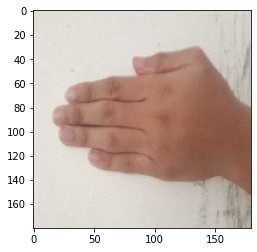

In [19]:
%matplotlib inline

# upload gambar yang akan diuji
uploaded = files.upload()

for fn in uploaded.keys():
 
  # memprediksi gambar
  path = fn
  img = image.load_img(path, target_size=(180,180))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

print("\n")
print("File", fn, "merupakan gambar:")
if classes[0][0]==1:
  print("paper")
elif classes[0][1]==1:
  print("rock")
else:
  print("scissors")